# Network

In [1]:
import geopandas as gpd

blocks_gdf = gpd.read_parquet('./../data/blocks.parquet')
blocks_gdf.head(2)

,geometry,land_use,is_living,build_floor_area,living_demand,living_area,share_living,business_area,share_business,site_area,...,capacity_bus_station,capacity_bus_stop,capacity_pier,capacity_animal_shelter,capacity_military_kom,capacity_prison,capacity_landfill,capacity_plant_nursery,capacity_greenhouse_complex,capacity_warehouse
id,,,,,,,,,,,,,,,,,,,,,
0,"POLYGON ((354918.622 6625258.829, 354901.464 6...",None,True,43840.686518,50.641057,30688.480678,2.199357,13152.205840,0.942581,804466.712114,...,0,0,0,0,0,0,0,0,0,0
1,"POLYGON ((355412.142 6623378.149, 355411.7 662...",transport,True,10294.395525,53.114392,2177.690063,0.431105,8116.705462,1.606820,23173.129862,...,0,0,0,0,0,0,0,0,0,0


Filter blocks getting only local ones for the example

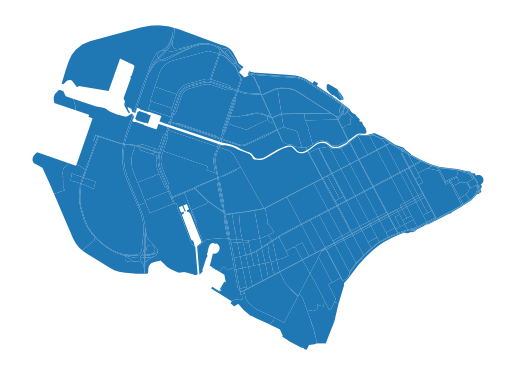

In [2]:
import osmnx as ox

local_crs = blocks_gdf.crs
polygon = ox.geocode_to_gdf('R1114252', by_osmid=True).to_crs(local_crs)
blocks_gdf = blocks_gdf[blocks_gdf.intersects(polygon.union_all())]
blocks_gdf.plot().set_axis_off()

## Calculating accessibility matrices

In [3]:
from blocksnet.relations import get_accessibility_graph 

### Getting graphs

In [4]:
graph_drive = get_accessibility_graph(blocks_gdf, 'drive')

2025-06-08 15:38:00.477 | WARNING  | blocksnet.relations.accessibility.graph.core:get_accessibility_graph:16 - CRS do not match IDUEDU required crs. Reprojecting
2025-06-08 15:38:00.551 | INFO     | iduedu.modules.drive_walk_builder:get_drive_graph_by_poly:91 - Downloading drive graph from OSM, it may take a while for large territory ...
2025-06-08 15:38:01.897 | WARNING  | iduedu.utils.utils:remove_weakly_connected_nodes:37 - Removing 24 nodes that form 23 trap components. These are groups where you can enter but can't exit (or vice versa). Keeping the largest strongly connected component (663 nodes).


In [5]:
graph_walk = get_accessibility_graph(blocks_gdf, 'walk')

2025-06-08 15:38:01.927 | WARNING  | blocksnet.relations.accessibility.graph.core:get_accessibility_graph:16 - CRS do not match IDUEDU required crs. Reprojecting


2025-06-08 15:38:01.969 | INFO     | iduedu.modules.drive_walk_builder:get_walk_graph:217 - Downloading walk graph from OSM, it may take a while for large territory ...


Calculating the weights of the walk graph:   0%|          | 0/48938 [00:00<?, ?it/s]

### Calculating distances from `blocks` to `nodes`

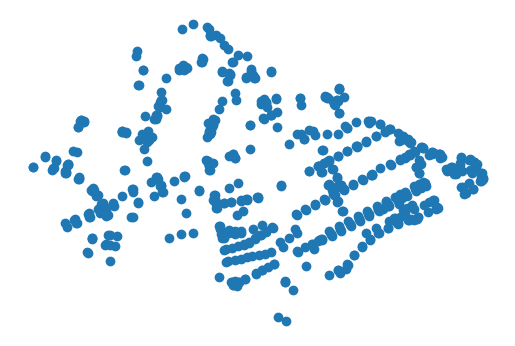

In [6]:
from blocksnet.relations import accessibility_graph_to_gdfs

nodes_gdf, _ = accessibility_graph_to_gdfs(graph_drive)
nodes_gdf.plot().set_axis_off()

In [7]:
from iduedu import get_adj_matrix_gdf_to_gdf

blocks_to_nodes = get_adj_matrix_gdf_to_gdf(blocks_gdf, nodes_gdf, graph_walk)

In [8]:
blocks_to_nodes.head()

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,0,1,2,3,4,5,6,7,8,9,...,653,654,655,656,657,658,659,660,661,662
id,,,,,,,,,,,,,,,,,,,,,
112,3410.0,3602.0,3526.0,3528.0,3408.0,3850.0,3856.0,3586.0,2840.0,3434.0,...,2690.0,3186.0,4052.0,3222.0,4356.0,4544.0,4156.0,4572.0,4952.0,4972.0
113,2096.0,2288.0,2212.0,2212.0,2094.0,2348.0,2354.0,2270.0,1179.0,1774.0,...,3318.0,3806.0,4708.0,3880.0,5212.0,5340.0,5012.0,5364.0,4676.0,5200.0
114,3920.0,4116.0,4036.0,4038.0,3918.0,4364.0,4368.0,4096.0,3352.0,3944.0,...,3200.0,3698.0,4564.0,3734.0,4864.0,5056.0,4668.0,5080.0,5464.0,5484.0
115,3046.0,3238.0,3160.0,3160.0,3040.0,3298.0,3302.0,3218.0,2128.0,2724.0,...,2974.0,3470.0,4368.0,3540.0,4732.0,4920.0,4532.0,4944.0,5160.0,5284.0
215,4116.0,4312.0,4232.0,4232.0,4112.0,4556.0,4560.0,4292.0,3758.0,4352.0,...,3124.0,3620.0,4452.0,3658.0,4372.0,4728.0,4148.0,4752.0,5392.0,5380.0


### Calculating distances from nodes to nodes

In [9]:
nodes_to_nodes = get_adj_matrix_gdf_to_gdf(nodes_gdf, nodes_gdf, graph_drive)

In [10]:
nodes_to_nodes.head()

/home/vasilstar/masterplanning/.venv/lib/python3.10/site-packages/pandas/io/formats/format.py:1458: RuntimeWarning: overflow encountered in cast
  has_large_values = (abs_vals > 1e6).any()


,0,1,2,3,4,5,6,7,8,9,...,653,654,655,656,657,658,659,660,661,662
0,0.000,17.375,371.50000,315.250000,215.0000,664.0,659.5,349.000,1181.0,1254.0,...,3626.0,3888.0,4696.0,3860.0,5392.0,5592.0,5080.0,5576.0,4276.0,5016.0
1,37.750,0.000,354.00000,297.750000,197.6250,647.0,642.0,331.750,1163.0,1237.0,...,3610.0,3870.0,4680.0,3842.0,5376.0,5576.0,5060.0,5556.0,4256.0,4996.0
2,267.500,285.000,0.00000,5.519531,107.1875,354.5,350.0,39.375,1281.0,944.5,...,3894.0,4156.0,4964.0,4128.0,5660.0,5860.0,5344.0,5844.0,4544.0,5284.0
3,323.750,341.000,56.15625,0.000000,163.3750,349.0,344.5,33.875,1275.0,939.0,...,3950.0,4212.0,5020.0,4184.0,5716.0,5916.0,5400.0,5900.0,4600.0,5340.0
4,160.375,177.750,532.00000,475.500000,0.0000,824.5,820.0,509.500,1341.0,1415.0,...,3788.0,4048.0,4856.0,4020.0,5552.0,5752.0,5240.0,5736.0,4436.0,5176.0


## Calculating OD matrix

In [11]:
services_dfs = []
for column in [c for c in blocks_gdf.columns if 'capacity_' in c]:
    services_df = blocks_gdf[[column]].rename(columns={column:'capacity'})
    services_dfs.append(services_df)

In [12]:
from blocksnet.analysis.network import origin_destination_matrix

od_mx = origin_destination_matrix(blocks_gdf, blocks_to_nodes, nodes_to_nodes, services_dfs)

2025-06-08 15:38:19.243 | INFO     | blocksnet.analysis.network.origin_destination.core:_validate_input:81 - Validating input data
2025-06-08 15:38:19.244 | INFO     | blocksnet.analysis.network.origin_destination.core:_calculate_diversity:51 - Calculating diversity and density
2025-06-08 15:38:19.633 | INFO     | blocksnet.analysis.network.origin_destination.core:_calculate_attractiveness:59 - Calculating attractiveness
2025-06-08 15:38:19.640 | INFO     | blocksnet.analysis.network.origin_destination.core:_calculate_nodes_weights:32 - Identifying nearest nodes to blocks
2025-06-08 15:38:19.646 | INFO     | blocksnet.analysis.network.origin_destination.core:_calculate_nodes_weights:37 - Calculating weights
2025-06-08 15:38:19.655 | INFO     | blocksnet.analysis.network.origin_destination.core:_calculate_nodes_weights:43 - Distributing
2025-06-08 15:38:19.659 | INFO     | blocksnet.analysis.network.origin_destination.core:_calculate_od_mx:72 - Calculating origin destination matrix


## Calculating roads congestion

In [16]:
from blocksnet.analysis.network import road_congestion

graph_congestion = road_congestion(od_mx, graph_drive)

2025-06-08 15:41:45.987 | INFO     | blocksnet.analysis.network.road_congestion.core:road_congestion:18 - Calculating shortest path
2025-06-08 15:41:47.616 | INFO     | blocksnet.analysis.network.road_congestion.core:road_congestion:21 - Evaluating congestion
100%|██████████| 663/663 [00:44<00:00, 15.04it/s]


In [17]:
_, edges_gdf = accessibility_graph_to_gdfs(graph_congestion)
edges_gdf.head()

length_meter  time_min  \
0 1          17.379     0.017   
1 339         8.024     0.008   
  340       245.966     0.246   
2 3           5.515     0.008   
  4         107.189     0.107   

                                                geometry  congestion  
0 1    LINESTRING (348610.46 6648540.586, 348595.032 ...    0.058759  
1 339  LINESTRING (348595.032 6648548.588, 348588.653...    0.019130  
  340  LINESTRING (348595.032 6648548.588, 348581.331...    0.040963  
2 3    LINESTRING (348859.015 6648442.978, 348857.583...    0.000718  
  4    LINESTRING (348859.015 6648442.978, 348847.224...    0.048565

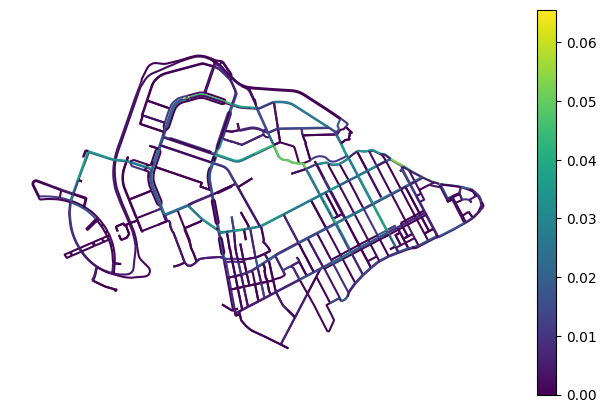

In [18]:
edges_gdf.plot('congestion', legend=True, figsize=(8,5)).set_axis_off()